In [1]:
import os

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist

In [2]:
CUR_DIR = os.path.abspath('')

DATA_DIR = Path(CUR_DIR).parent / "data" / "millionsong"
FILE_PATH = DATA_DIR/'triplets_metadata_spotify.csv'
df_origin = pd.read_csv(FILE_PATH, index_col = 0)

In [3]:

df_unique_values = df_origin.drop_duplicates(subset = ['song_name', 'artist_name'], keep='first').reset_index().drop('index', axis=1)
tracks_quanti_feats = df_unique_values.drop(['user', 'listening_count', 'song_name', 'release', 'artist_name', 
        'artist_familiarity', 'artist_hotttnesss', 'year', 'key', 'duration',
       'shs_perf', 'shs_work', 'explicit', 'mode', 'time_signature', 'release_date'], axis = 1)


In [4]:
scaler = StandardScaler()
scaler.fit(tracks_quanti_feats)
tracks_quanti_feats[tracks_quanti_feats.columns] = pd.DataFrame(scaler.fit_transform(tracks_quanti_feats), index=tracks_quanti_feats.index)

In [5]:
tracks_quanti_feats_names = pd.DataFrame(tracks_quanti_feats)
tracks_quanti_feats_names['song_name'] = df_unique_values['song_name']
tracks_quanti_feats_names['artist_name'] = df_unique_values['artist_name']


In [6]:

scaler = StandardScaler()
sel_columns = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
df_origin[sel_columns] = pd.DataFrame(scaler.fit_transform(df_origin[sel_columns]), index=df_origin.index)


In [7]:
def get_opt_clusters(df:pd.DataFrame, drop : list[str], user_id: str):
    
    # definition of df_user
    df_user = df[df['user']==user_id].drop(drop, axis=1).reset_index().drop(['index'], axis=1)

    # weights to apply to the kmeans
    user_listenings = df_user['listening_count']

    # eliminate weights from acoustic characteristics
    df_user = df_user.drop('listening_count', axis=1) 
    

    # broad exploration of number of clusters
    dist = []
    s_scores = []
    range = np.arange(2,len(df_user)-1)
    for i in range:
        clf = KMeans(n_clusters = i, n_init = 'auto', random_state=123)
        clf.fit(df_user, sample_weight=user_listenings)
        centroids = clf.cluster_centers_
        labels = clf.labels_
        score = silhouette_score(df_user, labels, metric='euclidean')
        s_scores.append(score)
        dist.append(sum(np.min(cdist(XA = centroids, XB = df_user, metric='euclidean'), axis = 0)) / len(df_user))
    
    # optimal number of clusters selection by silhouette score
    n_clusters = s_scores.index(max(s_scores))+2

    return range, s_scores, dist, n_clusters

In [8]:
def get_user_profiles(df: pd.DataFrame, drop : list[str],  user_id: str, n_clusters:int):
    """
    Takes a user_id string and 1 dataframe containg all original informations and whose acoustic characteristics are Standard scaled.
    Returns the acoustic characteristics of the user standard profile weighted by number of listenings (1 acoustic profile)   
    and the cluster centers centroids profiles based on Kmeans fit on optimal number of cluster found per user (n_clusters profiles)

    Parameters:
        df : whole dataframe with all acoustic characteristics Standard scaled
        user_id : str corresponding to the user id
   
    Return :
        
        standard_profile: list[list[float]] of size 1
        cluster_profile: list[list[float]] of size n_clusters
    """
    
    
    total_listening = df[df["user"] == user_id]["listening_count"].sum() 

    ## Standard profile: one profile where acoustic characteristics are weighted by listening_count
    '''
    hotness = 0
    familiarity = 0
    '''
    duration = 0
    dance = 0
    energy = 0
    loudness = 0
    speech = 0
    acoustic = 0
    instru = 0
    live = 0
    valence = 0
    tempo = 0
    
    # cumulative sum of user's  songs acoustic characteristics weighted by listening_count
    for index, row, in df[df["user"] == user_id].iterrows():
        '''
        hotness += row['artist_hotttnesss'] * row["listening_count"]
        familiarity += row['artist_familiarity'] * row["listening_count"]   
        '''
        #duration += row['duration'] * row["listening_count"]
        dance += row['danceability'] * row["listening_count"]
        energy += row['energy'] * row["listening_count"]
        loudness += row['loudness'] * row["listening_count"]
        speech += row['speechiness'] * row["listening_count"]
        acoustic += row['acousticness'] * row["listening_count"]
        instru += row['instrumentalness'] * row["listening_count"]
        live += row['liveness'] * row["listening_count"]
        valence += row['valence'] * row["listening_count"]
        tempo += row['tempo'] * row["listening_count"]

    # duration / total_listening, 

    # weighted average from cumulative sum of acoustic characteristics / total_listening to list of lists
    # valence missing
    standard_profile = [[dance / total_listening, energy / total_listening,
                        loudness / total_listening, speech / total_listening, acoustic / total_listening,
                        instru / total_listening, live / total_listening, valence/total_listening, tempo / total_listening]]

    ## Cluster profile
    
    # definition of df_user
    df_user = df[df['user']==user_id].drop(drop, axis=1).reset_index().drop(['index'], axis=1)

    # weights to apply to the kmeans
    user_listenings = df_user['listening_count']

    # eliminate weights from acoustic characteristics
    df_user = df_user.drop('listening_count', axis=1) 

    # training of kmeans with optimal number of clusters
    clf = KMeans(n_clusters = n_clusters, n_init = 'auto', random_state=123)
    clf.fit(df_user, sample_weight=user_listenings)
    centroids = clf.cluster_centers_
    labels = clf.labels_

    # distinct profiles as cluster centers centroids to list
    cluster_profile = centroids.tolist()

    
    return standard_profile, cluster_profile

Proximity measure - Numerical resolution

In [10]:
# var
acoustic_variables = ["Danceability", "Energy", "Loudness", "Speechiness", "Acousticness", "instrumentalness", "Liveness", "Valence", "Tempo"]
n_neighbors = 5

user_name = '22e08d5e101ab5b86dc394856d508e175a5242a6'
#user_name = 'af3ee32357049dd96231238bd1b019e8142ee6aa' # l'espagnol
#user_name = '3fa44653315697f42410a30cb766a4eb102080bb'
#user_name = "ec6dfcf19485cb011e0b22637075037aae34cf26"	
#user_name = '6a46aee45cc177cf8e2025e59d21c7939902deee'
#user_name = '716ed1ec67d67bfa05db3ffeb641d13f46dca6ec'
#user_name = 'd035c4a2b179ef8c756d73f9f3018ec7a87d8594'
#user_name = '72b7c0b7ef846805b61e7a82534beded246a95c2'
#user_name = 'b393acb0d2f15b13fb1377c2998b222f6e174619'
#user_name = 'b784fec0b1e04dbf02a2f095da6ec1e3a8561391'


#user_name ='19a7ec5c51a370817f99cf18decde4b8f469bfd3'
#user_name = '43e241eaa4d079ab2bdbd30231695f5563583af4	'



to_drop = ['user', 'song_name', 'release', 'artist_name', 'duration', 'artist_familiarity', 'artist_hotttnesss',
           'year', 'shs_perf', 'shs_work', 'key', 'mode', 'explicit', 'time_signature', 'release_date']


# func
range_n_clusters, silhouette_scores, distorsions, n_opt_cluster = get_opt_clusters(df=df_origin, drop=to_drop, user_id=user_name)

standard_profile, clusters_profiles = get_user_profiles(df=df_origin, drop=to_drop, user_id=user_name, n_clusters=n_opt_cluster)

In [11]:
OUTPUT_DIR = Path(CUR_DIR).parent / "figures/users_viz"

C:\Users\benoit\AppData\Local\Temp\ipykernel_26256\2023622959.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(121)


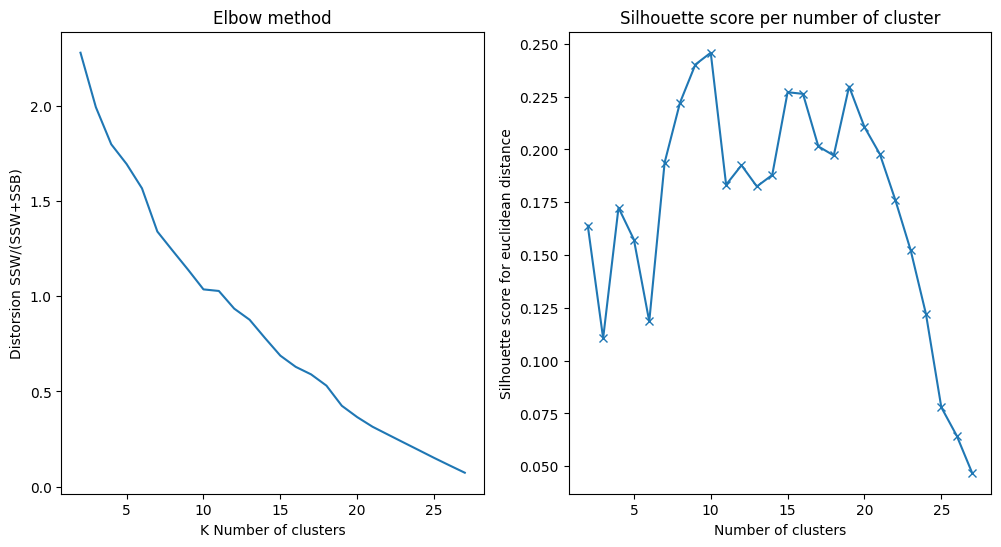

In [12]:
fig  = plt.subplots(figsize=(12, 6))

ax1 = plt.subplot(121)
ax1.plot(range_n_clusters, distorsions)
ax1.set_xlabel('K Number of clusters')
ax1.set_ylabel('Distorsion SSW/(SSW+SSB)')
ax1.set_title('Elbow method');

ax2 = plt.subplot(122)
ax2.plot(range_n_clusters, silhouette_scores, '-x')
ax2.set_xlabel("Number of clusters")
ax2.set_ylabel("Silhouette score for euclidean distance")
ax2.set_title('Silhouette score per number of cluster');

#plt.savefig(OUTPUT_DIR / (user_name + '_silhouette_scores.png'), dpi=200 )

In [18]:
from scipy.spatial import distance_matrix

def get_profile_neighbors(df_features, df_features_names: pd.DataFrame, profiles: list[list[float]], n_target : int = n_neighbors):
    
    '''
    user_profile = pd.DataFrame(columns=["hotness", "familiarity","danceability", "energy",
                                   "loudness", "speechiness", "acousticness",
                                   "instrumentalness", "liveness", "valence",
                                   "tempo"])
    '''
    user_profile = pd.DataFrame(columns=["danceability", "energy",
                                   "loudness", "speechiness", "acousticness",
                                   "instrumentalness", "liveness", "valence", 
                                   "tempo"])

    # append profile to the dataframe user_profile
    for i in range(len(profiles)):
        user_profile.loc[len(user_profile)] = profiles[i]


    # compute the distance matrix between all user_profiles and all songs features
    dist_mat = pd.DataFrame(distance_matrix(user_profile, df_features).T)
    #dist_mat = dist_mat.rename(columns={0 : 'distance'})
    

    # create similarity and disimilarity lists
    sim = []
    dis = []
    sim_id = []
    dis_id =[]

    # broadcast distance of matrix[i] to df_features_names containing song and artist names and sort values by distance[i]
    for i in range(len(profiles)):
        df_feats_names = df_features_names
        df_feats_names[i] = dist_mat[i]
        df_feats_names = df_feats_names.sort_values(by=i, ascending=True).reset_index().drop(['index'], axis=1)
        
        # for each profile create temporary sim and disim lists
        s = []
        d = []
        s_id = []
        d_id = []

        ## append each profile list the profile closest and furthest n_neighbors tracks and corresponding song-artist names 
        for j in range (n_target):
            
            
            s.append(df_feats_names.iloc[j, :9].values.flatten().tolist())
            s_id.append(' - '.join((df_feats_names.iloc[j, 9:11])))
            
            d.append(df_feats_names.iloc[len(df_feats_names)-1-j, :9].values.flatten().tolist())
            d_id.append(' - '.join((df_feats_names.iloc[len(df_feats_names)-1-j, 9:11])))
            
            '''
            s.append(df_feats_names.iloc[j, :8].values.flatten().tolist())
            s_id.append(' - '.join((df_feats_names.iloc[j, 8:10])))
            
            d.append(df_feats_names.iloc[len(df_feats_names)-1-j, :8].values.flatten().tolist())
            d_id.append(' - '.join((df_feats_names.iloc[len(df_feats_names)-1-j, 8:10])))
            '''

            
        sim.append(s)
        sim_id.append(s_id)
        dis.append(d)
        dis_id.append(d_id)

    return sim, dis, sim_id, dis_id

In [19]:
#similar, disimilar, sim_names, dis_names = get_profile_neighbors(tracks_quanti_feats, tracks_quanti_feats_names, standard_profile)
similar, disimilar, sim_names, dis_names = get_profile_neighbors(tracks_quanti_feats, tracks_quanti_feats_names, clusters_profiles)

In [20]:
print("Number of clusters", len(similar))
#print("Number of songs per cluster times number of cluster / nb of songs = proportion of songs of the database",  len(similar[0])* len(similar) / 27607)
fraction = round((len(similar[0])* len(similar) / 27607), 4) * 100

print('fraction of the song database suggested to the user ', fraction, "%" )


Number of clusters 10
fraction of the song database suggested to the user  0.18 %


In [33]:
## compare the fraction of songs of the database suggested to the user and the number of songs of his playlist actually detected by the kmeans algorithm
song_user = (df_origin[df_origin["user"] == user_name]['song_name'] + ' - ' + df_origin[df_origin["user"] == user_name]['artist_name']).tolist()


song_reco = []
for i in range(len(sim_names)):
    song_reco.extend(sim_names[i])

n_detected_songs = len([i for i in song_user if i in song_reco])

print(f"Number of songs of the user entire playlist detected by suggesting {n_neighbors} closest tracks to each of the {len(similar)} identified centroids :", \
      n_detected_songs, "hence", n_detected_songs / len(df_origin[df_origin["user"] == user_name])*100, "%")
          
print("Here are the detected song")
[i for i in song_user if i in song_reco]



Number of songs of the user entire playlist detected by suggesting 5 closest tracks to each of the 10 identified centroids : 10 hence 34.48275862068966 %
Here are the detected song


['Debaser - Pixies',
 'Tell Him - The Exciters',
 'Paradise By The Dashboard Light - Meat Loaf',
 'All My Only Dreams - The Wonders',
 'Everybodies Girl - Dwarves',
 'Fotzepolitic - Cocteau Twins',
 'I Will Deny - Dwarves',
 'Hits - Dwarves',
 'To Know Him Is To Love Him - The Teddy Bears',
 'Demonica - Dwarves']

In [34]:
from pprint import pprint
song_list = [i.split(' - ', 1)[0] for i in song_reco]
pprint(song_list)
artist_list = [i.split(' - ', 1)[1] for i in song_reco]
pprint(artist_list)

['Tú',
 'Strings',
 "Who'll Stop The Rain",
 'Cherry Red',
 'All My Only Dreams',
 'Drinking Song',
 'Money Talks',
 'Paradise By The Dashboard Light',
 'I Will Deny',
 'If I Had A Woman',
 'Everybodies Girl',
 'Migraine',
 'No Looking Back',
 'Half-Empty Halls',
 'A Stare Like Yours',
 'Madeline and Nine',
 'To Be Alive Again',
 'Spotlights',
 'Dead Space',
 'Paper Crowns',
 'To Know Him Is To Love Him',
 'If I was a Blackbird',
 'The Curse',
 'Rejoice',
 'Aye Waukin-O',
 'Fotzepolitic',
 'Shift Your Gaze',
 'Heavy Metal Shuffle',
 'Untitled',
 'Requiem: From Substance to Silence',
 'Hits',
 "Moon And Sun Part II: North's Son",
 'Swan',
 'Dungeon Bastard',
 'Envelope',
 'Debaser',
 'Musicatto',
 'Nick The Stripper',
 'Hacked To Pieces',
 'Silent Violence',
 'Tell Him',
 'Cherry Pie',
 'Rocket To God',
 'Something On Your Mind',
 'Lady Love',
 'Scottish And Proud',
 'Demonica',
 'The Truth of Trumpets',
 'Machine Gun Kelly',
 'Mind is Ugly']
['Jaguares',
 'Sofa Surfers',
 'Debbie Davie

In [35]:

df_user_temp = df_origin[df_origin["user"] == user_name].drop(df_origin.iloc[:,5: ], axis=1)
import dataframe_image as dfi 

def red_or_auto(x):
    # set font color to red for keys whose corresponding v is positive
    # all other values have default font color
    #return pd.DataFrame('', index=x.index, columns=x.columns).assign(song_name=np.where(x['song_name'] + ' - ' + x['artist_name'].isin(song_reco), "color:red", ''))
    return pd.DataFrame('', index=x.index, columns=x.columns).assign(song_name=np.where((x['song_name'].isin(song_list)) & (x['artist_name'].isin(artist_list)) , "color:red", ''),
                                                                     artist_name = (np.where((x['artist_name'].isin(artist_list)) & (x['song_name'].isin(song_list)), "color:red", '')))

df_styled = df_user_temp.style.apply(red_or_auto, axis=None, subset=['song_name', 'artist_name'])
df_styled



,user,listening_count,song_name,release,artist_name
1447406,22e08d5e101ab5b86dc394856d508e175a5242a6,1,Future Reflections,Oracular Spectacular,MGMT
1682768,22e08d5e101ab5b86dc394856d508e175a5242a6,1,Big Me,Foo Fighters,Foo Fighters
2214552,22e08d5e101ab5b86dc394856d508e175a5242a6,1,Debaser,Wave Of Mutilation: Best Of Pixies,Pixies
2293489,22e08d5e101ab5b86dc394856d508e175a5242a6,4,When A Man Loves A Woman,100 Timeless Love Songs,Percy Sledge
2768037,22e08d5e101ab5b86dc394856d508e175a5242a6,130,That Thing You Do!,That Thing You Do! Original Motion Picture Soundtrack,The Wonders
3029255,22e08d5e101ab5b86dc394856d508e175a5242a6,8,Tell Him,Girls of the 60's,The Exciters
3200016,22e08d5e101ab5b86dc394856d508e175a5242a6,5,Where Eagles Dare,First 7 Inches And Then Some,Sloppy Seconds
3267798,22e08d5e101ab5b86dc394856d508e175a5242a6,21,Paradise By The Dashboard Light,Discover Meat Loaf,Meat Loaf
3598454,22e08d5e101ab5b86dc394856d508e175a5242a6,55,All My Only Dreams,That Thing You Do! Original Motion Picture Soundtrack,The Wonders
3613185,22e08d5e101ab5b86dc394856d508e175a5242a6,178,Everybodies Girl,The Dwarves Are Young & Goodlooking,Dwarves


In [36]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots


for i in range(len(similar)):

    if (len(similar) == 1):
        profile = standard_profile
        std_prof = True
        prof_name = "Standard profile weighted by listening counts"
        fig_title = f"Most similar and different tracks from standard profile (blue) of user '{user_name}'"
        col1_title = "Closest tracks"
        col2_title = "Furthest tracks"
        fig_name = "avg_profile"
        fig_type = fig_name

    elif (len(similar) > 1):
        profile = clusters_profiles    
        std_prof = False
        prof_name = f"Cluster center centroid {i+1} profile" 
        fig_title = f"Most similar and different tracks from centroid {i+1} profile (blue) of user '{user_name}'"
        col1_title = f"Closest tracks from centroid {i+1}"
        col2_title = f"Furthest tracks from centroid {i+1}"
        fig_name = f"centroid_{i+1}_profile "
        fig_type = "centroids_profiles"

    min_sim = np.min(similar[i])
    if min_sim > np.min(profile[i]):
        min_sim = np.min(profile[i])

    max_sim = np.max(similar[i])
    if max_sim < np.max(profile[i]):
        max_sim = np.max(profile[i])

    min_dis = np.min(disimilar[i])
    if min_dis > np.min(profile[i]):
        min_dis = np.min(profile[i])

    max_dis = np.max(disimilar[i])
    if max_dis < np.max(profile[i]):
        max_dis = np.max(profile[i])
    
    tracks_titles = []
    for j in range(len(similar[i])):
        tracks_titles.append(sim_names[i][j])
        tracks_titles.append(dis_names[i][j])



    fig = make_subplots(rows=n_neighbors, cols=2,
                        shared_xaxes='columns', shared_yaxes='columns',
                        vertical_spacing = 0.1,
                        horizontal_spacing=0,
                        #column_titles = ["Closest tracks", "Furthest tracks"],
                        #row_heights = [0.9,0.9],
                        subplot_titles=tracks_titles,
                     specs = [[{'type': 'polar'}]*2]*n_neighbors)


    trace_profile = go.Scatterpolar(r = profile[i],
                                             theta = acoustic_variables,
                                             mode = "lines+markers", line_color='#636EFA',
                                             
                                                                                          
                                             name = prof_name)

    #https://community.plotly.com/t/plotly-colours-list/11730/3
    #colors_col2 = ['orange', '#8c564b', '#7f7f7f', '#2ca02c', 'pink' ]
    

    for j in range(len(similar[i])):
        
        fig.add_trace(trace_profile, row=j+1, col=1)

        fig.add_trace(go.Scatterpolar(
            r = similar[i][j],
            name = f"Closest track rank {j+1}",
            theta = acoustic_variables,
            line_color = '#EF553B',
            #text=["Foundbird - Papercuts"],
            #textposition="top center"
        ),  row=j+1, col=1)

        fig.add_trace(trace_profile, row=j+1, col=2)

        fig.add_trace(go.Scatterpolar(
            r = disimilar[i][j],
            name = f"Furthest track rank {j+1}",
            theta = acoustic_variables,
            line_color = '#B6E880',  #colors_col2[j],
        ),  row=j+1, col=2)

    

    fig.update_traces(fill='toself')#,
                      #mode = "lines+markers", line_color='indianred',
                      #marker =   dict(color='lightslategray', size=8, symbol='square'))

    
    fig.update_layout(
        height = 1600,
        width = 1200,
        #title_text = "Test",
        title= dict(text=fig_title,
                    x=0.5,
                    y=0.99,
                    #x_anchor = 'center',
                    #y_anchor = 'top',
                    font = dict(
                        #family = 'Courier New')
                        size = 18)),
                    #margin=dict(l=50, r=50, t=200, b=50),
                    margin=dict(l=50, r=50, t=200, b=50),
        #paper_bgcolor="LightSteelBlue",
        polar = dict(radialaxis = dict(showticklabels=False, ticks='' ), radialaxis_range = [min_sim,max_sim]), #radialaxis_range = [-10,10]),
                     #angularaxis = dict(showticklabels=False, ticks='')
        polar2 = dict(radialaxis = dict(showticklabels=False, ticks='' ), radialaxis_range = [min_dis,max_dis]),
        
        polar3 = dict(radialaxis = dict(showticklabels=False, ticks='' ), radialaxis_range = [min_sim,max_sim]),

        polar4 = dict(radialaxis = dict(showticklabels=False, ticks='' ), radialaxis_range = [min_dis,max_dis]),

        polar5 = dict(radialaxis = dict(showticklabels=False, ticks='' ), radialaxis_range = [min_sim,max_sim]),

        polar6 = dict(radialaxis = dict(showticklabels=False, ticks='' ), radialaxis_range = [min_dis,max_dis]),

        polar7 = dict(radialaxis = dict(showticklabels=False, ticks='' ), radialaxis_range = [min_sim,max_sim]),

        polar8 = dict(radialaxis = dict(showticklabels=False, ticks='' ), radialaxis_range = [min_dis,max_dis]),

        polar9 = dict(radialaxis = dict(showticklabels=False, ticks='' ), radialaxis_range = [min_sim,max_sim]),
        
        polar10 = dict(radialaxis = dict(showticklabels=False, ticks='' ), radialaxis_range = [min_dis,max_dis]),
                     
        showlegend=False
    )
    
    if len(similar) > 1:
        fig.add_annotation(x= 0.12, y = 1.09,
                           text = col1_title,
                           showarrow=False,
                           font = dict(color="black",
                                       size=20))
        fig.add_annotation(x= 0.9, y = 1.09,
                           text = col2_title,
                           showarrow=False,
                           font = dict(color="black",
                                       size=22))
    elif len(similar) == 1:
            fig.add_annotation(x= 0.19, y = 1.09,
                           text = col1_title,
                           showarrow=False,
                           font = dict(color="black",
                                       size=22))
            fig.add_annotation(x= 0.81, y = 1.09,
                           text = col2_title,
                           showarrow=False,
                           font = dict(color="black",
                                       size=22))

    fig.add_annotation(x= 0.005, y = 1.09,
                           text = "Rank",
                           showarrow=False,
                           font = dict(color="black",
                                       size=22))
    fig.add_annotation(x= 0.01, y = 1.05,
                           text = '1',
                           showarrow=False,
                           font = dict(color="black",
                                       size=22))
    
    fig.add_annotation(x= 0.01, y = 0.84,
                           text = '2',
                           showarrow=False,
                           font = dict(color="black",
                                       size=22))
    
    fig.add_annotation(x= 0.01, y = 0.608,
                           text = '3',
                           showarrow=False,
                           font = dict(color="black",
                                       size=22))
    
    fig.add_annotation(x= 0.01, y = 0.389,
                           text = '4',
                           showarrow=False,
                           font = dict(color="black",
                                       size=22))
    
    fig.add_annotation(x= 0.01, y = 0.159,
                           text = '5',
                           showarrow=False,
                           font = dict(color="black",
                                       size=22))

    annot =list(fig.layout.annotations)
    annot[0].y = 1.03
    annot[1].y = 1.03
    annot[2].y = 0.82 
    annot[3].y = 0.82 
    annot[4].y = 0.6 
    annot[5].y = 0.6 
    annot[6].y = 0.38 
    annot[7].y = 0.38 
    annot[8].y = 0.16 
    annot[9].y = 0.16 

    fig.layout.annotations = annot

    #https://plotly.com/python/reference/layout/polar/
    fig.update_polars(
        radialaxis_showticklabels = False
    )
    
    pprint(tracks_titles)
    names = set()
    fig.for_each_trace(
        lambda trace:
            trace.update(showlegend=False)
            if (trace.name in names) else names.add(trace.name))

    fig.show()
    #fig.write_html(file = OUTPUT_DIR / (user_name + '_' + fig_name + ".html"), include_plotlyjs = 'cdn')

['Tú - Jaguares',
 'Introduction - Paul Horn',
 'Strings - Sofa Surfers',
 "Jaden's Interlude - Will Smith",
 "Who'll Stop The Rain - Debbie Davies",
 'Intro - Swell',
 'Cherry Red - ZZ Top',
 'Holmes Depot - George Lopez',
 'All My Only Dreams - The Wonders',
 'Socoro - George Lopez']


['Drinking Song - The Gits',
 '(Kanji) Ooioo - OOIOO',
 'Money Talks - Cryptic Slaughter',
 'Intro - Swell',
 'Paradise By The Dashboard Light - Meat Loaf',
 'Introduction - Paul Horn',
 'I Will Deny - Dwarves',
 "Jaden's Interlude - Will Smith",
 'If I Had A Woman - Sloppy Seconds',
 'Rain - Shel Silverstein']


['Everybodies Girl - Dwarves',
 '(Kanji) Ooioo - OOIOO',
 'Migraine - The Coral',
 'Introduction - Paul Horn',
 'No Looking Back - SSM',
 'Intro - Swell',
 'Half-Empty Halls - The Evaporators',
 'Rain - Shel Silverstein',
 'A Stare Like Yours - The Thermals',
 '40 Break - Brotha Lynch Hung']


['Madeline and Nine - Mike Doughty',
 'Introduction - Paul Horn',
 'To Be Alive Again - Journey',
 '(Kanji) Ooioo - OOIOO',
 'Spotlights - Let Go',
 "Jaden's Interlude - Will Smith",
 'Dead Space - Able Baker Fox',
 'Intro - Swell',
 'Paper Crowns - Burning Airlines',
 '40 Break - Brotha Lynch Hung']


['To Know Him Is To Love Him - The Teddy Bears',
 'Rain - Shel Silverstein',
 'If I was a Blackbird - Silly Wizard',
 "Jaden's Interlude - Will Smith",
 'The Curse - Josh Ritter',
 'Intro - Swell',
 'Rejoice - Il Divo',
 'Socoro - George Lopez',
 'Aye Waukin-O - Eddi Reader',
 'ER - George Lopez']


['Fotzepolitic - Cocteau Twins',
 'Intro - Swell',
 'Shift Your Gaze - The Life And Times',
 "Jaden's Interlude - Will Smith",
 'Heavy Metal Shuffle - Reagan Youth',
 'Intro - Tech N9ne',
 'Untitled - Cephalic Carnage',
 'Introduction - Paul Horn',
 'Requiem: From Substance to Silence - Minsk',
 'Seat Belts - Brian Regan']


['Hits - Dwarves',
 'Intro - Swell',
 "Moon And Sun Part II: North's Son - Amorphis",
 'Rain - Shel Silverstein',
 'Swan - Unwound',
 "Jaden's Interlude - Will Smith",
 'Dungeon Bastard - Akimbo',
 'Introduction - Paul Horn',
 'Envelope - Unwound',
 'Thoughtfulness (skit) - The Pharcyde']


['Debaser - Pixies',
 'Introduction - Paul Horn',
 'Musicatto - Kansas',
 '(Kanji) Ooioo - OOIOO',
 'Nick The Stripper - The Birthday Party',
 'Intro - Swell',
 'Hacked To Pieces - Six Feet Under',
 'Rain - Shel Silverstein',
 'Silent Violence - Six Feet Under',
 'Thoughtfulness (skit) - The Pharcyde']


['Tell Him - The Exciters',
 'Introduction - Paul Horn',
 'Cherry Pie - Sade',
 "Jaden's Interlude - Will Smith",
 'Rocket To God - Daryl Hall & John Oates',
 '(Kanji) Ooioo - OOIOO',
 'Something On Your Mind - Mighty Joe Young',
 'Holmes Depot - George Lopez',
 'Lady Love - Lou Rawls',
 '40 Break - Brotha Lynch Hung']


['Scottish And Proud - The Real McKenzies',
 'Intro - Swell',
 'Demonica - Dwarves',
 'Introduction - Paul Horn',
 'The Truth of Trumpets - Alove For Enemies',
 "Jaden's Interlude - Will Smith",
 'Machine Gun Kelly - Angelic Upstarts',
 '(Kanji) Ooioo - OOIOO',
 'Mind is Ugly - War Tapes',
 '40 Break - Brotha Lynch Hung']


In [114]:
#dfi.export(df_styled, OUTPUT_DIR / (user_name + '_' + fig_type + '_df.png'), max_rows=-1)